In [1]:
from tqdm import tqdm
from gensim.utils import simple_preprocess
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
import emoji

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
# %cd drive/MyDrive/datasets/

In [4]:
df = pd.read_csv("train/SemEval2018-T3-train-taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_test = pd.read_csv("goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_replace = pd.read_csv("test_TaskA/SemEval2018-T3_input_test_taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')

In [5]:
df_test['Tweet text'] = df_test['Tweet text'].apply(emoji.demojize)

# df = df.append(df_test, ignore_index=True)

In [6]:
def word_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith(("@", "#"))]
    return len(newlist)

def tag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("@")]
    return len(newlist)

def hashtag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("#")]
    return len(newlist)

def has_emoji(s):
    splitted = s.split()
    newlist = [x for x in splitted if x != ":" and x.startswith(":") and x.endswith(":")]
    return len(newlist)

def clean_text(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith((":", "@", "#"))]
    return ' '.join(newlist)

### dodani featuresi ###
def link_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith(('http:', 'https:'))]
    return len(newlist)

def smiley_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if not re.match(r'([\:\;\=][\(\)PD]+)+', x)]
    return len(newlist)

def exclamation_mark_counter(s):
    return s.count('!')

In [7]:
df['length'] = df['Tweet text'].apply(len)
df['word_count'] = df['Tweet text'].apply(word_counter)
df['tag_count'] = df['Tweet text'].apply(tag_counter)
df['hashtag_count'] = df['Tweet text'].apply(hashtag_counter)
df['link_count'] = df['Tweet text'].apply(link_counter)
df['smiley_count'] = df['Tweet text'].apply(smiley_counter)
df['exclamation_mark_count'] = df['Tweet text'].apply(exclamation_mark_counter)
df['has_emoji'] = df['Tweet text'].apply(has_emoji)
df['clean_text'] = df['Tweet text'].apply(clean_text)

In [8]:
nlp = spacy.load("en_core_web_md") # treba instalirat ako nemate, s md cemo dobivat bolji performans a i dalje nije prevelik

In [9]:
# ###lista svih listi tokena

# all_tokens_list = []
# for index, row in df.iterrows():
#     token_list = []
#     doc = nlp(row['clean_text'])
#     for token in doc:
#         token_list.append(token)
#     all_tokens_list.append(token_list)

In [10]:
df_train = df.sample(frac=0.7)
df_validation = df.drop(df_train.index)

## Topic Modeling

In [11]:
tweet_text_train = df_train[['Tweet text']]
tweet_text_validation = df_validation[['Tweet text']]

tweet_text_train.head(15)

,Tweet text
1135,@MarcotteJN @KillerKalen yeah I'm avoiding you...
3312,@Wields Ill see you in the Finals
285,"Thanks @AirAsia, for nothing. All my family we..."
2876,@sommelierkeith hope you had a nice Xmas babes X
2824,@FunnyIines: DONT SAY ANYTHING JUST RT https:/...
1835,Lol at people saying they're turning 13 this y...
2428,I love that my body can't handle school stress...
199,Church sign of the day: How would you feel if ...
3365,@hollis51 gerrymandering neither party will gi...
2336,@GG_Studio:Congratulations GG for giving us am...


In [12]:
def preprocess_words(s):
    '''Removes tags, emojis, links, smiley faces, hashtag signs, stopwords and changes the case to lower.'''
    ret_list = []

    is_tag = lambda w: w.startswith('@')
    is_emoji = lambda w: w != ":" and w.startswith(":") and w.endswith(":")
    is_link = lambda w: w.startswith("http:") or w.startswith("https:")
    is_hashtag = lambda w: w.startswith("#")
    is_smiley = lambda w: re.match(r'([\:\;\=][\(\)PD]+)+', w)
    is_not_stopword = lambda w: w not in nlp.Defaults.stop_words
    
    for i, s_i in enumerate(s):
        w_arr = s_i.split()
        w2 = []
        for w in w_arr:
            if is_tag(w) or is_emoji(w) or is_link(w):
                pass
            
            elif is_hashtag(w):
                w_tmp = w.replace('#', '')
                if w_tmp != '':
                    w2.append(w_tmp.lower())
            
            elif is_smiley(w):
                w_tmp = re.sub(r'([\:\;\=][\(\)PD]+)+', '', w)
                if w_tmp != '':
                    w2.append(w_tmp.lower())
            
            elif is_not_stopword(w):
                w2.append(w.lower())
            
        ret_list.append(' '.join(w2))
    return ret_list

tweet_text_train = tweet_text_train.apply(preprocess_words)
tweet_text_validation = tweet_text_validation.apply(preprocess_words)

In [13]:
def lemmatize(s):
    '''Lemmatizes the words in the sentences'''
    return [[w.lemma_ for w in nlp(s_i)] for s_i in s]

def join_docs(s):
    '''Joins the strings inside the inner list of a nested list'''
    return [' '.join([w for w in s_i]) for s_i in s]

tweet_text_train = tweet_text_train.apply(lemmatize)
tweet_text_validation = tweet_text_validation.apply(lemmatize)

In [14]:
tweet_text_train = join_docs(tweet_text_train['Tweet text'])
tweet_text_validation = join_docs(tweet_text_validation['Tweet text'])

In [15]:
def gensim_preprocess(s):
    '''Uses gensims preprocess function to prepare the data for topic modeling'''
    return [' '.join(simple_preprocess(s_i, deacc=True)) for s_i in s]

tweet_text_train = gensim_preprocess(tweet_text_train)
tweet_text_validation = gensim_preprocess(tweet_text_validation)

In [16]:
display(tweet_text_train[1401])
display(tweet_text_train[1416])
display(tweet_text_train[1428])

'playstation everything be awesome'

'ah soul make sunday morning work bearable cold happy'

'online shopping credit card umm justbrowse'

In [17]:
def get_likelihoods_and_perplexities(train, validation, model_range, batch_size=64):
    '''
    Returns a list of train and validation log likelihoods and perplexities for LDA models
    in the given range using the given vectorizer
    '''
    models, logl_train, logl_val, perp_train, perp_val = [], [], [], [], []
    for i in model_range:
        lda = LatentDirichletAllocation(
            n_components=i,
            max_iter=10,
            learning_method='online',
            batch_size=batch_size,
            evaluate_every = -1,
            n_jobs = -1,
        )
        
        lda.fit(train)
        
        logl_train.append(lda.score(train))
        logl_val.append(lda.score(validation))
        perp_train.append(lda.perplexity(train))
        perp_val.append(lda.perplexity(validation))
        models.append(lda)
                         
    return models, logl_train, logl_val, perp_train, perp_val
                        
vectorizer = CountVectorizer(
    analyzer='word',
    min_df=0.1,
    max_df=0.6,
)

vectorizer2 = TfidfVectorizer(
    analyzer='word',
    min_df=0.1,
    max_df=0.6,
)

tweet_text_count_train = vectorizer.fit_transform(tweet_text_train)
tweet_text_count_validation = vectorizer.transform(tweet_text_validation)

tweet_text_tfidf_train = vectorizer2.fit_transform(tweet_text_train)
tweet_text_tfidf_validation = vectorizer2.transform(tweet_text_validation)

In [18]:
# models, logl_train, logl_val, perp_train, perp_val = get_likelihoods_and_perplexities(tweet_text_count_train, \
#                                                             tweet_text_count_validation, range(2, 50))

In [19]:
# model_range = list(range(2, 50))

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].plot(model_range, logl_train, 'o-')
# axs[0].plot(model_range, logl_val, 'o-')

# axs[1].plot(model_range, perp_train, 'o-')
# axs[1].plot(model_range, perp_val, 'o-')


In [20]:
# from tmtoolkit.topicmod import tm_lda
# from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
# from tmtoolkit.topicmod.evaluate import results_by_parameter
# from tmtoolkit.topicmod.visualize import plot_eval_results


# const_params = {
#     'n_iter': 10,
#     'eta':0.01,
# }

# # https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html#Evaluation-of-topic-models
# # https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/

# # alpha    - for a prior over the document-specific topic distributions
# #          - important for sparsity (low value means less impact - document contains a mixture of only few topics)
# # eta/beta - for a prior over the topic-specific word distributions
# #          - high beta value means a lower impact of word sparsity - each topic will contain most of the words of the corpus
# #          - low beta value means the topics should be more specific, i.e. their word probabilities will be less uniform,
# # low beta + low alpha

# var_params = [
#     {'n_topics': k, 'alpha': 1/k}
#     for k in range(5, 101, 100)
# ]


# eval_results = evaluate_topic_models(
#     tweet_text_count_train,
#     varying_parameters=var_params,
#     constant_parameters=const_params,
#     coherence_mimno_2011_top_n=10,
#     coherence_mimno_2011_include_prob=True,
#     return_models=True
# )

# eval_results[:3]  # only show first three models

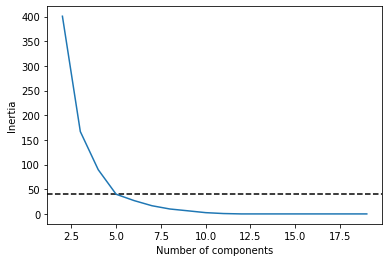

In [40]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

inertia = []
for i in range(2, 20):
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    inertia.append(model.inertia_)
plt.axhline(inertia[3], c='k',  linestyle='dashed')
plt.plot(list(range(2, 20)), inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()